In [43]:
#merging both data at a customer x month level to create single data source with repetitions
import pandas as pd

In [44]:
df1 = pd.read_csv("cust_meta_hub.csv")

In [4]:
df1.head()

,CUSTOMER_ID,SNAPSHOT_MONTH,MARKETING_HUB_TIER,MARKETING_HUB_MRR,MARKETING_HUB_MRR_CANCELED,SALES_HUB_TIER,SALES_HUB_MRR,SALES_HUB_MRR_CANCELED,Unnamed: 8,Unnamed: 9
0,C00020862,2024-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN
1,C00020863,2024-01,STarter,14.16,NaN,NaN,NaN,NaN,NaN,NaN
2,C00020864,2024-01,STarter,9.49,NaN,NaN,NaN,NaN,NaN,NaN
3,C00020865,2024-01,Pro,346.97,NaN,NaN,NaN,NaN,NaN,NaN
4,C00020866,2024-01,Pro,295.94,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df2 = pd.read_csv("cust_int_hub.csv")

In [46]:
df1['join_field'] = df1['CUSTOMER_ID'].astype(str) + "_" + df1['SNAPSHOT_MONTH'].astype(str)

In [47]:
df2['join_field'] = df2['CUSTOMER_ID'].astype(str) + "_" + df2['SNAPSHOT_MONTH'].astype(str)

In [48]:
df = df1.merge(df2, left_on='join_field', right_on='join_field', how='left')

In [42]:
#final table view
df.head()

,CUSTOMER_ID_x,SNAPSHOT_MONTH_x,MARKETING_HUB_TIER,MARKETING_HUB_MRR,MARKETING_HUB_MRR_CANCELED,SALES_HUB_TIER,SALES_HUB_MRR,SALES_HUB_MRR_CANCELED,Unnamed: 8,Unnamed: 9,...,has_mkt,has_sales,is_multi_hub,is_int,mkt_rank,sales_rank,mkt_mrr,sales_mrr,total_mrr,returned_next_month
0,C00020862,2024-01-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN,...,True,True,True,True,0.0,3.0,674.14,-17.55,656.59,True
1,C00020862,2024-01-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN,...,True,True,True,True,0.0,3.0,674.14,-17.55,656.59,True
2,C00020862,2024-01-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN,...,True,True,True,True,0.0,3.0,674.14,-17.55,656.59,True
3,C00020862,2024-01-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN,...,True,True,True,True,0.0,3.0,674.14,-17.55,656.59,True
4,C00020862,2024-01-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN,...,True,True,True,True,0.0,3.0,674.14,-17.55,656.59,True


In [50]:
# Unique list of customers per month to avoid double-counting due to integrations
df_unique = df.drop_duplicates(subset=['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])

In [57]:
df_unique.head()

,CUSTOMER_ID_x,SNAPSHOT_MONTH_x,MARKETING_HUB_TIER,MARKETING_HUB_MRR,MARKETING_HUB_MRR_CANCELED,SALES_HUB_TIER,SALES_HUB_MRR,SALES_HUB_MRR_CANCELED,Unnamed: 8,Unnamed: 9,join_field,CUSTOMER_ID_y,SNAPSHOT_MONTH_y,INTEGRATION,has_marketing,has_sales
0,C00020862,2024-01,Ent,674.14,NaN,Enterprise,-17.55,NaN,NaN,NaN,C00020862_2024-01,C00020862,2024-01,GoogleCalendar,True,True
6,C00020863,2024-01,STarter,14.16,NaN,NaN,NaN,NaN,NaN,NaN,C00020863_2024-01,C00020863,2024-01,Gmail,True,False
8,C00020864,2024-01,STarter,9.49,NaN,NaN,NaN,NaN,NaN,NaN,C00020864_2024-01,C00020864,2024-01,Instagram,True,False
11,C00020865,2024-01,Pro,346.97,NaN,NaN,NaN,NaN,NaN,NaN,C00020865_2024-01,C00020865,2024-01,GoogleCalendar,True,False
13,C00020866,2024-01,Pro,295.94,NaN,NaN,NaN,NaN,NaN,NaN,C00020866_2024-01,C00020866,2024-01,Gmail,True,False


In [75]:
#  monthly transacting customers 

# 1. Fill NaNs with 0 to ensure logical comparisons work
cols = ['MARKETING_HUB_MRR', 'SALES_HUB_MRR', 'MARKETING_HUB_MRR_CANCELED', 'SALES_HUB_MRR_CANCELED']
df1[cols] = df1[cols].fillna(0)

# 2. Apply your requested logic:
# - Must be paying (> 0) for Marketing OR Sales
# - Must have 0 Canceled MRR for both
is_paying = (df1['MARKETING_HUB_MRR'] > 0) | (df1['SALES_HUB_MRR'] > 0)
no_cancellation = (df1['MARKETING_HUB_MRR_CANCELED'] == 0) & (df1['SALES_HUB_MRR_CANCELED'] == 0)

# 3. Filter and Group
active_customers = df1[is_paying & no_cancellation]

monthly_trend = active_customers.groupby('SNAPSHOT_MONTH')['CUSTOMER_ID'].nunique().reset_index()
monthly_trend.columns = ['Month', 'Total_Active_Customers']

print(monthly_trend)


     Month  Total_Active_Customers
0  2024-01                    9184
1  2024-02                    9221
2  2024-03                    9421
3  2024-04                    9628
4  2024-05                    9859
5  2024-06                   10066


In [55]:
#tier wise customer count

# Marketing Tier Breakdown
mkt_tier_summary = df_unique.groupby(['SNAPSHOT_MONTH_x', 'MARKETING_HUB_TIER'])['CUSTOMER_ID_x'].count().unstack().fillna(0)

# Sales Tier Breakdown
sales_tier_summary = df_unique.groupby(['SNAPSHOT_MONTH_x', 'SALES_HUB_TIER'])['CUSTOMER_ID_x'].count().unstack().fillna(0)

print(mkt_tier_summary)
print(sales_tier_summary)

MARKETING_HUB_TIER   Ent  Enterprise    Pro  Professional  STarter  Starter
SNAPSHOT_MONTH_x                                                           
2024-01             77.0       766.0  124.0        3684.0     55.0   5176.0
2024-02              0.0       981.0    0.0        3844.0      0.0   5001.0
2024-03              0.0      1145.0    0.0        3871.0      0.0   4844.0
2024-04              0.0      1287.0    0.0        3899.0      0.0   4739.0
2024-05              0.0      1451.0    0.0        3957.0      0.0   4668.0
2024-06              0.0      1592.0    0.0        3982.0      0.0   4692.0
SALES_HUB_TIER    Enterprise  Professional  Starter
SNAPSHOT_MONTH_x                                   
2024-01                  667           738      811
2024-02                  685           846      895
2024-03                  761           969      960
2024-04                  848          1082     1041
2024-05                  931          1171     1171
2024-06                 1026

In [56]:
#month wise sales and marketing tier wise breakdown
summary = df_unique.groupby(['SNAPSHOT_MONTH_x', 'MARKETING_HUB_TIER', 'SALES_HUB_TIER']).agg(
    total_customers=('CUSTOMER_ID_x', 'nunique')
).reset_index()

print(summary)

   SNAPSHOT_MONTH_x MARKETING_HUB_TIER SALES_HUB_TIER  total_customers
0           2024-01                Ent     Enterprise                8
1           2024-01                Ent   Professional                5
2           2024-01                Ent        Starter                5
3           2024-01         Enterprise     Enterprise               59
4           2024-01         Enterprise   Professional               54
..              ...                ...            ...              ...
58          2024-06       Professional   Professional              581
59          2024-06       Professional        Starter              229
60          2024-06            Starter     Enterprise              294
61          2024-06            Starter   Professional              300
62          2024-06            Starter        Starter              656

[63 rows x 4 columns]


In [63]:
# overall mrr trends

# 1. Deduplicate the data
# We keep only one row per customer per month to avoid overcounting MRR
df_unique = df.drop_duplicates(subset=['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x']).copy()

# 2. Clean Sales MRR
# Remove negative values and set them to 0 as requested
df_unique.loc[df_unique['SALES_HUB_MRR'] < 0, 'SALES_HUB_MRR'] = 0

# 3. Fill NaNs with 0 for calculation
df_unique['MARKETING_HUB_MRR'] = df_unique['MARKETING_HUB_MRR'].fillna(0)
df_unique['SALES_HUB_MRR'] = df_unique['SALES_HUB_MRR'].fillna(0)

# 4. Calculate Monthly MRR Trends
mrr_trends = df_unique.groupby('SNAPSHOT_MONTH_x').agg({
    'MARKETING_HUB_MRR': 'sum',
    'SALES_HUB_MRR': 'sum'
}).reset_index()

# Rename columns for clarity
mrr_trends.columns = ['Month', 'Total_Marketing_MRR', 'Total_Sales_MRR']

# 5. Optional: Calculate Trends by Tier (Deep Dive)
mkt_tier_mrr = df_unique.groupby(['SNAPSHOT_MONTH_x', 'MARKETING_HUB_TIER'])['MARKETING_HUB_MRR'].sum().unstack().fillna(0)
sales_tier_mrr = df_unique.groupby(['SNAPSHOT_MONTH_x', 'SALES_HUB_TIER'])['SALES_HUB_MRR'].sum().unstack().fillna(0)

print("--- Overall MRR Trend ---")
print(mrr_trends)

--- Overall MRR Trend ---
     Month  Total_Marketing_MRR  Total_Sales_MRR
0  2024-01           2202446.03       1116382.03
1  2024-02           2351329.31       1180294.67
2  2024-03           2528248.51       1312901.93
3  2024-04           2676529.83       1452310.20
4  2024-05           2879012.18       1589302.72
5  2024-06           3021948.46       1738751.24


In [64]:
# month wise marketing, sales, and cancelled MRR

# 1. Deduplicate: One row per customer per month
df_unique = df.drop_duplicates(subset=['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x']).copy()

# 2. Data Cleaning
# Remove negative Sales MRR (set to 0)
df_unique.loc[df_unique['SALES_HUB_MRR'] < 0, 'SALES_HUB_MRR'] = 0

# Fill NaNs with 0 for all MRR and Cancellation columns
cols_to_fix = [
    'MARKETING_HUB_MRR', 'MARKETING_HUB_MRR_CANCELED', 
    'SALES_HUB_MRR', 'SALES_HUB_MRR_CANCELED'
]
df_unique[cols_to_fix] = df_unique[cols_to_fix].fillna(0)

# 3. Calculate Monthly Trends including Cancellations
mrr_summary = df_unique.groupby('SNAPSHOT_MONTH_x').agg({
    'MARKETING_HUB_MRR': 'sum',
    'MARKETING_HUB_MRR_CANCELED': 'sum',
    'SALES_HUB_MRR': 'sum',
    'SALES_HUB_MRR_CANCELED': 'sum'
}).reset_index()

# 4. Optional: Calculate Net MRR (New MRR minus Cancellations)
mrr_summary['NET_MARKETING_MRR'] = mrr_summary['MARKETING_HUB_MRR'] - mrr_summary['MARKETING_HUB_MRR_CANCELED']
mrr_summary['NET_SALES_MRR'] = mrr_summary['SALES_HUB_MRR'] - mrr_summary['SALES_HUB_MRR_CANCELED']

# Rename for clean output
mrr_summary.columns = [
    'Month', 
    'Mkt_MRR', 'Mkt_Canceled', 
    'Sales_MRR', 'Sales_Canceled',
    'Net_Mkt_MRR', 'Net_Sales_MRR'
]

print(mrr_summary)

     Month     Mkt_MRR  Mkt_Canceled   Sales_MRR  Sales_Canceled  Net_Mkt_MRR  \
0  2024-01  2202446.03     109854.18  1116382.03        73834.45   2092591.85   
1  2024-02  2351329.31     133589.87  1180294.67        70461.54   2217739.44   
2  2024-03  2528248.51     131832.56  1312901.93        63552.58   2396415.95   
3  2024-04  2676529.83     125478.45  1452310.20        72851.47   2551051.38   
4  2024-05  2879012.18     141964.72  1589302.72        72491.53   2737047.46   
5  2024-06  3021948.46     153002.97  1738751.24        84057.74   2868945.49   

   Net_Sales_MRR  
0     1042547.58  
1     1109833.13  
2     1249349.35  
3     1379458.73  
4     1516811.19  
5     1654693.50  


In [68]:
# Segmenting customers into Marketing only, sales only, or both active

# 1. Fill NaNs with 0
cols = ['MARKETING_HUB_MRR', 'SALES_HUB_MRR', 'MARKETING_HUB_MRR_CANCELED', 'SALES_HUB_MRR_CANCELED']
df1[cols] = df1[cols].fillna(0)

# 2. Filter out any cancellations first (as per your previous rule)
df_no_churn = df1[(df1['MARKETING_HUB_MRR_CANCELED'] == 0) & (df1['SALES_HUB_MRR_CANCELED'] == 0)].copy()

# 3. Create Flags for Hub Activity
df_no_churn['is_mkt'] = df_no_churn['MARKETING_HUB_MRR'] > 0
df_no_churn['is_sales'] = df_no_churn['SALES_HUB_MRR'] > 0

# 4. Create the 3 specific segments
# Only Marketing: Mkt is True AND Sales is False
df_no_churn['mkt_only'] = (df_no_churn['is_mkt']) & (~df_no_churn['is_sales'])

# Only Sales: Sales is True AND Mkt is False
df_no_churn['sales_only'] = (~df_no_churn['is_mkt']) & (df_no_churn['is_sales'])

# Both: Both are True
df_no_churn['both_active'] = (df_no_churn['is_mkt']) & (df_no_churn['is_sales'])

# 5. Group by Month and count Unique Customer IDs for each segment
monthly_split = df_no_churn.groupby('SNAPSHOT_MONTH').agg(
    marketing_active_only=('CUSTOMER_ID', lambda x: x[df_no_churn.loc[x.index, 'mkt_only']].nunique()),
    sales_active_only=('CUSTOMER_ID', lambda x: x[df_no_churn.loc[x.index, 'sales_only']].nunique()),
    both_active=('CUSTOMER_ID', lambda x: x[df_no_churn.loc[x.index, 'both_active']].nunique())
).reset_index()

print(monthly_split)

  SNAPSHOT_MONTH  marketing_active_only  sales_active_only  both_active
0        2024-01                   7271                104         1809
1        2024-02                   7108                227         1886
2        2024-03                   7010                345         2066
3        2024-04                   6956                447         2225
4        2024-05                   6929                566         2364
5        2024-06                   6971                659         2436


In [70]:
#Average Monthly Churn (Overall)

# 1. Fill NaNs to ensure logic holds
cols = ['MARKETING_HUB_MRR', 'SALES_HUB_MRR', 'MARKETING_HUB_MRR_CANCELED', 'SALES_HUB_MRR_CANCELED']
df1[cols] = df1[cols].fillna(0)

# 2. Define User Status per Month
# Note: We use a deduplicated version to count unique customers
df_status = df1.drop_duplicates(subset=['CUSTOMER_ID', 'SNAPSHOT_MONTH']).copy()

def get_status(row):
    # Churned: Has any cancellation MRR
    if row['MARKETING_HUB_MRR_CANCELED'] > 0 or row['SALES_HUB_MRR_CANCELED'] > 0:
        return 'Churned'
    # Paying: No cancellation AND has positive MRR in either hub
    elif row['MARKETING_HUB_MRR'] > 0 or row['SALES_HUB_MRR'] > 0:
        return 'Paying'
    else:
        return 'Other'

df_status['User_Status'] = df_status.apply(get_status, axis=1)

# 3. Count users per status per month
monthly_counts = df_status.groupby(['SNAPSHOT_MONTH', 'User_Status']).size().unstack(fill_value=0)

# 4. Calculate proportions per month (Distribution %)
monthly_dist = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100

# 5. Calculate the Average Distribution across all months
avg_distribution = monthly_dist[['Paying', 'Churned']].mean().reset_index()
avg_distribution.columns = ['Status', 'Average_Percentage']

print("--- Average Monthly Distribution ---")
print(avg_distribution)

--- Average Monthly Distribution ---
    Status  Average_Percentage
0   Paying           92.041663
1  Churned            7.958337


In [71]:
# Month wise churn trends

# 1. Setup and Deduplicate
cols = ['MARKETING_HUB_MRR', 'SALES_HUB_MRR', 'MARKETING_HUB_MRR_CANCELED', 'SALES_HUB_MRR_CANCELED']
df1[cols] = df1[cols].fillna(0)

# Get one record per customer per month
df_monthly = df1.drop_duplicates(subset=['CUSTOMER_ID', 'SNAPSHOT_MONTH']).copy()

# 2. Define "Active" status (Has any MRR > 0 and no cancellations)
df_monthly['is_active'] = (
    ((df_monthly['MARKETING_HUB_MRR'] > 0) | (df_monthly['SALES_HUB_MRR'] > 0)) & 
    (df_monthly['MARKETING_HUB_MRR_CANCELED'] == 0) & 
    (df_monthly['SALES_HUB_MRR_CANCELED'] == 0)
)

# 3. Sort by customer and month to ensure the shift works correctly
df_monthly = df_monthly.sort_values(['CUSTOMER_ID', 'SNAPSHOT_MONTH'])

# 4. Look ahead: Get the status of the NEXT month for the same customer
df_monthly['next_month_active'] = df_monthly.groupby('CUSTOMER_ID')['is_active'].shift(-1)

# 5. Identify Full Churners
# Logic: Active this month AND (Next month status is False OR next month doesn't exist/NaN)
# Note: We usually exclude the most recent month in the dataset because we don't know the "next month" yet.
df_monthly['full_churn'] = (df_monthly['is_active'] == True) & (df_monthly['next_month_active'] == False)

# 6. Aggregate results
full_churn_trend = df_monthly.groupby('SNAPSHOT_MONTH').agg(
    total_active_customers=('is_active', 'sum'),
    full_churn_count=('full_churn', 'sum')
).reset_index()

# Calculate Churn Rate %
full_churn_trend['full_churn_rate_%'] = (full_churn_trend['full_churn_count'] / full_churn_trend['total_active_customers']) * 100

print(full_churn_trend)

  SNAPSHOT_MONTH  total_active_customers  full_churn_count  full_churn_rate_%
0        2024-01                    9184               780           8.493031
1        2024-02                    9221               745           8.079384
2        2024-03                    9421               691           7.334678
3        2024-04                    9628               726           7.540507
4        2024-05                    9859               827           8.388275
5        2024-06                   10066                 0           0.000000


In [45]:
#New vs Repeat Customer MRR

# 1. Setup and Deduplicate
df_clean = df1.drop_duplicates(subset=['CUSTOMER_ID', 'SNAPSHOT_MONTH']).copy()
df_clean[['MARKETING_HUB_MRR', 'SALES_HUB_MRR']] = df_clean[['MARKETING_HUB_MRR', 'SALES_HUB_MRR']].fillna(0)
df_clean['TOTAL_MRR'] = df_clean['MARKETING_HUB_MRR'] + df_clean['SALES_HUB_MRR']

# 2. Sort to ensure time-series consistency
df_clean = df_clean.sort_values(['CUSTOMER_ID', 'SNAPSHOT_MONTH'])

# 3. Get the "Previous Month MRR" for every customer
df_clean['prev_month_mrr'] = df_clean.groupby('CUSTOMER_ID')['TOTAL_MRR'].shift(1)

# 4. Define Recurring vs. New Revenue
# Recurring: Paid > 0 last month AND Paid > 0 this month
df_clean['is_recurring'] = (df_clean['prev_month_mrr'] > 0) & (df_clean['TOTAL_MRR'] > 0)

# 5. Summarize Monthly
recurring_summary = df_clean.groupby('SNAPSHOT_MONTH').agg(
    total_revenue=('TOTAL_MRR', 'sum'),
    true_recurring_revenue=('TOTAL_MRR', lambda x: df_clean.loc[x.index[df_clean.loc[x.index, 'is_recurring']], 'TOTAL_MRR'].sum()),
    new_customer_revenue=('TOTAL_MRR', lambda x: df_clean.loc[x.index[~df_clean.loc[x.index, 'is_recurring']], 'TOTAL_MRR'].sum())
).reset_index()

# 6. Calculate Average Recurring Revenue
avg_recurring = recurring_summary['true_recurring_revenue'].mean()

print(recurring_summary)
print(f"\nAverage True Recurring Revenue: ${avg_recurring:,.2f}")

  SNAPSHOT_MONTH  total_revenue  true_recurring_revenue  new_customer_revenue
0        2024-01     3318757.86                    0.00            3318757.86
1        2024-02     3531623.98              3350349.05             181274.93
2        2024-03     3841150.44              3598041.42             243109.02
3        2024-04     4128840.03              3913701.67             215138.36
4        2024-05     4468314.90              4224435.75             243879.15
5        2024-06     4760699.70              4510406.73             250292.97

Average True Recurring Revenue: $3,266,155.77


In [48]:
# Integration Adoption across Sales & Marketing Hub

# Data Cleaning
df['is_mkt'] = df['MARKETING_HUB_TIER'].notna()
df['is_sales'] = df['SALES_HUB_TIER'].notna()

# 1. Total Monthly Integration Users & Hub Share
# We deduplicate to count unique customers per month
monthly_unique = df.drop_duplicates(subset=['CUSTOMER_ID_y', 'SNAPSHOT_MONTH_y'])

monthly_summary = monthly_unique.groupby('SNAPSHOT_MONTH_y').agg(
    total_integration_users=('CUSTOMER_ID_y', 'nunique'),
    marketing_hub_users=('is_mkt', 'sum'),
    sales_hub_users=('is_sales', 'sum')
).reset_index()

# Calculate Share %
monthly_summary['mkt_share_pct'] = (monthly_summary['marketing_hub_users'] / monthly_summary['total_integration_users']) * 100
monthly_summary['sales_share_pct'] = (monthly_summary['sales_hub_users'] / monthly_summary['total_integration_users']) * 100

print("--- Monthly Hub Share ---")
print(monthly_summary)

--- Monthly Hub Share ---
  SNAPSHOT_MONTH_y  total_integration_users  marketing_hub_users  \
0          2024-01                     9622                 9510   
1          2024-02                     9726                 9488   
2          2024-03                     9921                 9564   
3          2024-04                    10119                 9667   
4          2024-05                    10404                 9827   
5          2024-06                    10747                10058   

   sales_hub_users  mkt_share_pct  sales_share_pct  
0             2140      98.836001        22.240698  
1             2360      97.552951        24.264857  
2             2627      96.401572        26.479186  
3             2899      95.533155        28.649076  
4             3191      94.454056        30.670896  
5             3419      93.588909        31.813529  


In [79]:
# Integration Adoption across PLatform & Sales & Marketing Hub

# 1. Setup & Cleaning
# Deduplicate to one row per customer per month for the base universe
df_monthly = df.drop_duplicates(subset=['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x']).copy()

# Fill NaNs for Hub Tiers to identify Hub users
df_monthly['has_mkt'] = df_monthly['MARKETING_HUB_TIER'].notna()
df_monthly['has_sales'] = df_monthly['SALES_HUB_TIER'].notna()

# 2. Calculate Totals and Shares
monthly_stats = df_monthly.groupby('SNAPSHOT_MONTH_x').agg(
    total_base_users=('CUSTOMER_ID_x', 'nunique'),
    # Count only where customer_id_y exists (Integration users)
    integration_users=('CUSTOMER_ID_y', 'nunique'),
    # Hub users within the base
    mkt_hub_users=('has_mkt', 'sum'),
    sales_hub_users=('has_sales', 'sum')
).reset_index()

# 3. Calculate Adoption Shares
monthly_stats['mkt_share_of_total_%'] = (monthly_stats['mkt_hub_users'] / monthly_stats['total_base_users']) * 100
monthly_stats['sales_share_of_total_%'] = (monthly_stats['sales_hub_users'] / monthly_stats['total_base_users']) * 100

print("--- Monthly Base vs. Integration Share ---")
print(monthly_stats)

--- Monthly Base vs. Integration Share ---
  SNAPSHOT_MONTH_x  total_base_users  integration_users  mkt_hub_users  \
0          2024-01              9996               9622           9882   
1          2024-02             10070               9726           9826   
2          2024-03             10229               9921           9860   
3          2024-04             10395              10119           9925   
4          2024-05             10675              10404          10076   
5          2024-06             10974              10747          10266   

   sales_hub_users  mkt_share_of_total_%  sales_share_of_total_%  
0             2216             98.859544               22.168868  
1             2426             97.576961               24.091360  
2             2690             96.392609               26.297781  
3             2971             95.478595               28.581049  
4             3273             94.388759               30.660422  
5             3492             93.54

In [81]:
#Integration app vs user count monthly trend

# Filter for rows that actually have an integration
df_integrations = df[df['CUSTOMER_ID_y'].notna()].copy()

# Split by integration type per month
int_type_split = df_integrations.groupby(['SNAPSHOT_MONTH_x', 'INTEGRATION'])['CUSTOMER_ID_y'].nunique().unstack(fill_value=0)

print("\n--- Monthly Integration Type Split ---")
print(int_type_split)


--- Monthly Integration Type Split ---
INTEGRATION       Calendly  Canva  Eventbrite  Facebook Ads  FacebookAds  \
SNAPSHOT_MONTH_x                                                           
2024-01               2180   3173        2803          1197          104   
2024-02               2230   3205        2851          1638            0   
2024-03               2322   3291        2934          2029            0   
2024-04               2420   3349        3042          2480            0   
2024-05               2510   3417        3112          2954            0   
2024-06               2652   3514        3221          3513            0   

INTEGRATION       Gmail  Google Ads  Google Calendar  GoogleAds  \
SNAPSHOT_MONTH_x                                                  
2024-01            2632        2823             2457        129   
2024-02            2694        2993             2560          0   
2024-03            2777        3081             2647          0   
2024-04         

In [82]:
# Count integrations per user per month (only for those who have at least one)
int_counts = df_integrations.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_y'])['INTEGRATION'].count().reset_index()

# Group into buckets (1, 2, 3, 4, 5+)
def bucket_count(c):
    return str(c) if c < 5 else '5+'

int_counts['int_bucket'] = int_counts['INTEGRATION'].apply(bucket_count)

# Final Distribution
monthly_dist = int_counts.groupby(['SNAPSHOT_MONTH_x', 'int_bucket']).size().unstack(fill_value=0)

print("\n--- Monthly Distribution: Integrations per Customer ---")
print(monthly_dist)


--- Monthly Distribution: Integrations per Customer ---
int_bucket           1     2     3     4    5+
SNAPSHOT_MONTH_x                              
2024-01           1398  2228  2347  1780  1869
2024-02           1321  2152  2332  1870  2051
2024-03           1232  2065  2371  1953  2300
2024-04           1134  1958  2375  2040  2612
2024-05           1078  1865  2438  2178  2845
2024-06           1002  1810  2465  2291  3179


In [85]:
# High level hypothesis summary - integrations adoption trends, hub wise integrations, integration ladder (integration/customer)

# --- PREP: Data Standardization ---
df['is_mkt'] = df['MARKETING_HUB_TIER'].notna()
df['is_sales'] = df['SALES_HUB_TIER'].notna()

# ---------------------------------------------------------
# CHAPTER 1: Building the Master Funnel
# We group by the 'Base User' and 'Month' to see the status of every customer
# ---------------------------------------------------------
funnel_base = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'CUSTOMER_ID_y': 'first',       # If any row has a Y ID, this will capture it
    'is_mkt': 'max',                # If any row shows Marketing Hub, flag as True
    'is_sales': 'max',              # If any row shows Sales Hub, flag as True
    'INTEGRATION': 'count'          # Count how many integration rows exist for this user
}).reset_index()

# Define Activation Status
funnel_base['is_activated'] = funnel_base['CUSTOMER_ID_y'].notna()

# ---------------------------------------------------------
# CHAPTER 2: The Activation Trend
# Story: "Out of everyone in our database this month, how many turned on the lights?"
# ---------------------------------------------------------
monthly_story = funnel_base.groupby('SNAPSHOT_MONTH_x').agg(
    total_customers=('CUSTOMER_ID_x', 'count'),
    activated_customers=('is_activated', 'sum')
).reset_index()

monthly_story['activation_rate'] = (monthly_story['activated_customers'] / monthly_story['total_customers']) * 100

print("--- CHAPTER 2: ACTIVATION RATE TREND ---")
print(monthly_story[['SNAPSHOT_MONTH_x', 'activated_customers', 'activation_rate']])
print("\n")


# ---------------------------------------------------------
# CHAPTER 3: Product-Led Activation
# Story: "Are Marketing users or Sales users more likely to activate?"
# ---------------------------------------------------------
hub_activation = funnel_base[funnel_base['is_activated']].groupby('SNAPSHOT_MONTH_x').agg(
    mkt_active=('is_mkt', 'sum'),
    sales_active=('is_sales', 'sum')
).reset_index()

print("--- CHAPTER 3: WHICH HUB DRIVES ACTIVATION? ---")
print(hub_activation)
print("\n")


# ---------------------------------------------------------
# CHAPTER 4: Depth of Activation (The Engagement Ladder)
# Story: "Once activated, do they stop at 1 integration or go deeper?"
# ---------------------------------------------------------
def engagement_ladder(count):
    if count == 0: return '0: Not Activated'
    if count == 1: return '1: Trialing'
    if count <= 3: return '2: Engaging'
    return '3: Integrated/Power User'

funnel_base['ladder_step'] = funnel_base['INTEGRATION'].apply(engagement_ladder)

ladder_story = funnel_base.groupby(['SNAPSHOT_MONTH_x', 'ladder_step']).size().unstack(fill_value=0)

print("--- CHAPTER 4: THE ENGAGEMENT LADDER ---")
print(ladder_story)

--- CHAPTER 2: ACTIVATION RATE TREND ---
  SNAPSHOT_MONTH_x  activated_customers  activation_rate
0       2024-01-01                 9622        96.258503
1       2024-02-01                 9726        96.583913
2       2024-03-01                 9921        96.988953
3       2024-04-01                10119        97.344877
4       2024-05-01                10404        97.461358
5       2024-06-01                10747        97.931474


--- CHAPTER 3: WHICH HUB DRIVES ACTIVATION? ---
  SNAPSHOT_MONTH_x  mkt_active  sales_active
0       2024-01-01        9510          2140
1       2024-02-01        9488          2360
2       2024-03-01        9564          2627
3       2024-04-01        9667          2899
4       2024-05-01        9827          3191
5       2024-06-01       10058          3419


--- CHAPTER 4: THE ENGAGEMENT LADDER ---
ladder_step       0: Not Activated  1: Trialing  2: Engaging  \
SNAPSHOT_MONTH_x                                               
2024-01-01              

In [11]:
#  Integrations per customer and monthly trend

# 1. Prepare the Grain: One row per Customer per Month
# We count how many integrations (y) exist for every base customer (x)
integration_stats = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'CUSTOMER_ID_y': 'count',  # This counts the number of integration records
    'is_mkt': 'max',
    'is_sales': 'max'
}).reset_index()

integration_stats.rename(columns={'CUSTOMER_ID_y': 'integration_count'}, inplace=True)

# ---------------------------------------------------------
# STORY PART A: Average Depth of Activation
# ---------------------------------------------------------
# We only look at "Activated" users (those with > 0 integrations)
activated_only = integration_stats[integration_stats['integration_count'] > 0]

monthly_depth = activated_only.groupby('SNAPSHOT_MONTH_x').agg(
    avg_integrations_per_customer=('integration_count', 'mean'),
    median_integrations_per_customer=('integration_count', 'median'),
    total_active_integrations=('integration_count', 'sum')
).reset_index()

# ---------------------------------------------------------
# STORY PART B: Growth Velocity (Month-over-Month)
# ---------------------------------------------------------
monthly_depth['prev_month_total'] = monthly_depth['total_active_integrations'].shift(1)
monthly_depth['integration_growth_rate_%'] = (
    (monthly_depth['total_active_integrations'] - monthly_depth['prev_month_total']) / 
    monthly_depth['prev_month_total'] * 100
)

print("--- ACTIVATION DEPTH & GROWTH TREND ---")
print(monthly_depth[['SNAPSHOT_MONTH_x', 'avg_integrations_per_customer', 'integration_growth_rate_%']])

# ---------------------------------------------------------
# STORY PART C: The Power-User Pivot (Segmented Growth)
# ---------------------------------------------------------
# We want to see how the "Density" of your customers is changing
def get_density_bucket(count):
    if count == 1: return 'Single-Tool (Trialing)'
    if count <= 3: return 'Multi-Tool (Engaged)'
    return 'Power User (Sticky)'

activated_only['density_segment'] = activated_only['integration_count'].apply(get_density_bucket)

density_growth = activated_only.groupby(['SNAPSHOT_MONTH_x', 'density_segment']).size().unstack(fill_value=0)

print("\n--- SEGMENTED ADOPTION GROWTH ---")
print(density_growth)

--- ACTIVATION DEPTH & GROWTH TREND ---
  SNAPSHOT_MONTH_x  avg_integrations_per_customer  integration_growth_rate_%
0          2024-01                       3.175847                        NaN
1          2024-02                       3.259099                   3.730611
2          2024-03                       3.362060                   5.227459
3          2024-04                       3.481866                   5.630340
4          2024-05                       3.571126                   5.452275
5          2024-06                       3.676189                   6.335792


<ipython-input-11-269b0d599da5>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activated_only['density_segment'] = activated_only['integration_count'].apply(get_density_bucket)



--- SEGMENTED ADOPTION GROWTH ---
density_segment   Multi-Tool (Engaged)  Power User (Sticky)  \
SNAPSHOT_MONTH_x                                              
2024-01                           4575                 3649   
2024-02                           4484                 3921   
2024-03                           4436                 4253   
2024-04                           4333                 4652   
2024-05                           4303                 5023   
2024-06                           4275                 5470   

density_segment   Single-Tool (Trialing)  
SNAPSHOT_MONTH_x                          
2024-01                             1398  
2024-02                             1321  
2024-03                             1232  
2024-04                             1134  
2024-05                             1078  
2024-06                             1002  


In [12]:
# Retention rate for customers with integration

# 1. Grain: One row per Customer (X) per Month, identifying if they were Activated (Y)
# We use Customer_ID_x as the base and check if Customer_ID_y exists
df_monthly = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'CUSTOMER_ID_y': 'first'
}).reset_index()

# Mark if the user was activated this month
df_monthly['is_activated'] = df_monthly['CUSTOMER_ID_y'].notna()

# 2. Sort to ensure time-series consistency for the "Next Month" lookahead
df_monthly = df_monthly.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])

# 3. The "Lookahead" Logic: Did they remain activated next month?
# We shift by -1 to see the NEXT month's status for the SAME user
df_monthly['active_next_month'] = df_monthly.groupby('CUSTOMER_ID_x')['is_activated'].shift(-1)

# 4. Define our Story Segments:
# - REPEATER: Active this month AND Active next month
# - CHURNER (De-activated): Active this month AND NOT Active next month
# - NEWLY ACTIVATED: Not Active this month AND Active next month

def categorize_retention(row):
    if row['is_activated'] == True:
        if row['active_next_month'] == True:
            return 'Repeater (Retained)'
        elif row['active_next_month'] == False:
            return 'Integration Churner'
    return 'Other'

df_monthly['activation_status'] = df_monthly.apply(categorize_retention, axis=1)

# 5. Aggregate the Story by Month
retention_story = df_monthly[df_monthly['is_activated']].groupby('SNAPSHOT_MONTH_x')['activation_status'].value_counts().unstack(fill_value=0)

# 6. Calculate Integration Retention Rate
import pandas as pd

# 1. Prepare the Grain: Count integrations per Customer (X) per Month
df_monthly = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'CUSTOMER_ID_y': 'count',  # Number of integrations
}).reset_index()

df_monthly.rename(columns={'CUSTOMER_ID_y': 'int_count'}, inplace=True)
df_monthly['is_activated'] = df_monthly['int_count'] > 0

# 2. Segment users: Multi vs Single
def get_segment(count):
    if count == 1: return 'Single-Integration'
    if count > 1: return 'Multi-Integration'
    return 'Not Activated'

df_monthly['user_segment'] = df_monthly['int_count'].apply(get_segment)

# 3. Time-Series Shift: Did they remain activated next month?
df_monthly = df_monthly.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])
df_monthly['active_next_month'] = df_monthly.groupby('CUSTOMER_ID_x')['is_activated'].shift(-1)

# 4. Filter for Activated Users only to calculate Retention
activated_df = df_monthly[df_monthly['is_activated']].copy()

# A "Repeater" is someone active this month who stays active next month
activated_df['is_repeater'] = activated_df['active_next_month'] == True

# 5. The Story: Compare Retention Rates by Segment
retention_comparison = activated_df.groupby(['SNAPSHOT_MONTH_x', 'user_segment']).agg(
    total_users=('CUSTOMER_ID_x', 'count'),
    repeaters=('is_repeater', 'sum')
).reset_index()

retention_comparison['retention_rate_%'] = (
    retention_comparison['repeaters'] / retention_comparison['total_users']
) * 100

# Pivot for a clean comparison table
story_table = retention_comparison.pivot(
    index='SNAPSHOT_MONTH_x', 
    columns='user_segment', 
    values='retention_rate_%'
)

print("--- THE ACTIVATION DEPTH STORY: RETENTION RATES ---")
print(story_table)

print("--- THE ACTIVATION RETENTION STORY ---")
print(retention_story)

--- THE ACTIVATION RETENTION STORY ---
activation_status  Integration Churner  Other  Repeater (Retained)  \
SNAPSHOT_MONTH_x                                                     
2024-01                             25    511                 9086   
2024-02                             21    539                 9166   
2024-03                             18    531                 9372   
2024-04                             21    482                 9616   
2024-05                              9    492                 9903   
2024-06                              0  10747                    0   

activation_status  retention_rate_%  
SNAPSHOT_MONTH_x                     
2024-01                   99.725606  
2024-02                   99.771416  
2024-03                   99.808307  
2024-04                   99.782090  
2024-05                   99.909201  
2024-06                         NaN  


In [16]:
# Does time to integration have any effect on retention

import pandas as pd

# 1. Standardize dates to ensure accurate math
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])
df['SNAPSHOT_MONTH_y'] = pd.to_datetime(df['SNAPSHOT_MONTH_y'])

# 2. Identify the "Activation Window" for each customer
# We only care about the very first time they integrated (First Y) vs when they joined (X)
activation_moments = df[df['CUSTOMER_ID_y'].notna()].groupby('CUSTOMER_ID_x').agg({
    'SNAPSHOT_MONTH_x': 'min', # Signup Month
    'SNAPSHOT_MONTH_y': 'min'  # First Integration Month
}).reset_index()

# 3. Calculate "Months to Activate"
# 0 = Same month as signup, 1 = Month after signup, etc.
activation_moments['months_to_activate'] = (
    (activation_moments['SNAPSHOT_MONTH_y'].dt.year - activation_moments['SNAPSHOT_MONTH_x'].dt.year) * 12 +
    (activation_moments['SNAPSHOT_MONTH_y'].dt.month - activation_moments['SNAPSHOT_MONTH_x'].dt.month)
)

# 4. Define Velocity Cohorts
def get_velocity_label(m):
    if m <= 0: return '0: Instant (Same Month)'
    if m == 1: return '1: Fast (Next Month)'
    return '2: Delayed (2+ Months)'

activation_moments['velocity_cohort'] = activation_moments['months_to_activate'].apply(get_velocity_label)

# 5. Calculate Retention: Did they use an integration AGAIN the month after their first one?
# Create a 'target month' which is the month after their first integration
activation_moments['target_return_month'] = activation_moments['SNAPSHOT_MONTH_y'] + pd.DateOffset(months=1)

# Get a unique list of (Customer, Month) pairs from the integration logs to check against
integration_usage = df[df['CUSTOMER_ID_y'].notna()][['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_y']].drop_duplicates()
integration_usage['is_retained'] = True

# Merge to see if they appeared in the logs during their 'target_return_month'
final_analysis = pd.merge(
    activation_moments,
    integration_usage,
    left_on=['CUSTOMER_ID_x', 'target_return_month'],
    right_on=['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_y'],
    how='left'
)

# 6. Build the Final Story Table
velocity_story = final_analysis.groupby('velocity_cohort').agg(
    total_users=('CUSTOMER_ID_x', 'count'),
    retained_users=('is_retained', 'sum')
).reset_index()

velocity_story['retention_rate_%'] = (velocity_story['retained_users'] / velocity_story['total_users']) * 100

print("--- THE ACTIVATION VELOCITY STORY ---")
print(velocity_story)

--- THE ACTIVATION VELOCITY STORY ---
           velocity_cohort  total_users retained_users retention_rate_%
0  0: Instant (Same Month)        13368          11830        88.494913


In [17]:
# Month wise integration per user distribution count and % share

import pandas as pd

# 1. Filter for the Activated Universe (where an integration exists)
df_int = df[df['CUSTOMER_ID_y'].notna()].copy()

# 2. Calculate the "Density" per Customer per Month
# We count how many integration rows exist for each unique base user (x)
density_df = df_int.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg(
    integration_count=('INTEGRATION', 'count')
).reset_index()

# 3. Create the requested Buckets: 1, 2, 3, and 3+
def get_density_bucket(count):
    if count == 1: return '1 Integration'
    if count == 2: return '2 Integrations'
    if count == 3: return '3 Integrations'
    return '3+ Integrations' # This captures 4, 5, etc.

density_df['bucket'] = density_df['integration_count'].apply(get_density_bucket)

# 4. Aggregate: Total Customer Count per Bucket across Months
# This transforms the data into a time-series distribution table
density_story = density_df.groupby(['SNAPSHOT_MONTH_x', 'bucket']).size().unstack(fill_value=0)

# Ensure columns are in the correct logical order for the story
cols_order = ['1 Integration', '2 Integrations', '3 Integrations', '3+ Integrations']
density_story = density_story.reindex(columns=cols_order)

print("--- MONTHLY CUSTOMER COUNT BY INTEGRATION DENSITY ---")
print(density_story)

# 5. Optional: View as Percentages to see the 'Shift' in Adoption
density_pct = density_story.div(density_story.sum(axis=1), axis=0) * 100
print("\n--- PERCENTAGE DISTRIBUTION (%) ---")
print(density_pct.round(2))

--- MONTHLY CUSTOMER COUNT BY INTEGRATION DENSITY ---
bucket            1 Integration  2 Integrations  3 Integrations  \
SNAPSHOT_MONTH_x                                                  
2024-01-01                 1398            2228            2347   
2024-02-01                 1321            2152            2332   
2024-03-01                 1232            2065            2371   
2024-04-01                 1134            1958            2375   
2024-05-01                 1078            1865            2438   
2024-06-01                 1002            1810            2465   

bucket            3+ Integrations  
SNAPSHOT_MONTH_x                   
2024-01-01                   3649  
2024-02-01                   3921  
2024-03-01                   4253  
2024-04-01                   4652  
2024-05-01                   5023  
2024-06-01                   5470  

--- PERCENTAGE DISTRIBUTION (%) ---
bucket            1 Integration  2 Integrations  3 Integrations  \
SNAPSHOT_MONTH_x 

In [18]:
# Month wise integration per user distribution tabular

import pandas as pd

# 1. Filter for the Activated Universe (where an integration exists)
df_int = df[df['CUSTOMER_ID_y'].notna()].copy()

# 2. Calculate the "Density" per Customer per Month
density_df = df_int.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg(
    integration_count=('INTEGRATION', 'count')
).reset_index()

# 3. Define the Buckets
def get_density_bucket(count):
    if count == 1: return '1_Integration'
    if count == 2: return '2_Integrations'
    if count == 3: return '3_Integrations'
    return '3_Plus_Integrations'

density_df['bucket'] = density_df['integration_count'].apply(get_density_bucket)

# 4. Create the Pivot Table for Excel
# Using .pivot_table ensures a structured format
excel_table = density_df.pivot_table(
    index='SNAPSHOT_MONTH_x', 
    columns='bucket', 
    values='CUSTOMER_ID_x', 
    aggfunc='nunique', 
    fill_value=0
)

# 5. Reorder columns logically and add a Total column
cols_order = ['1_Integration', '2_Integrations', '3_Integrations', '3_Plus_Integrations']
excel_table = excel_table.reindex(columns=cols_order)
excel_table['Total_Active_Users'] = excel_table.sum(axis=1)

# 6. Reset index so SNAPSHOT_MONTH_x becomes a column (easier for Excel filtering)
excel_output = excel_table.reset_index()

# Print the result in a copy-pasteable format
print(excel_output.to_string(index=False))

# Optional: Directly save to CSV if you prefer
# excel_output.to_csv('integration_density_analysis.csv', index=False)

SNAPSHOT_MONTH_x  1_Integration  2_Integrations  3_Integrations  3_Plus_Integrations  Total_Active_Users
      2024-01-01           1398            2228            2347                 3649                9622
      2024-02-01           1321            2152            2332                 3921                9726
      2024-03-01           1232            2065            2371                 4253                9921
      2024-04-01           1134            1958            2375                 4652               10119
      2024-05-01           1078            1865            2438                 5023               10404
      2024-06-01           1002            1810            2465                 5470               10747


In [20]:
# Integration impact on MRR & ARPU

import pandas as pd

# 1. Prepare Revenue and Integration Flags
df['TOTAL_MRR'] = df['MARKETING_HUB_MRR'].fillna(0) + df['SALES_HUB_MRR'].fillna(0)
df['is_integrated'] = df['CUSTOMER_ID_y'].notna()

# 2. Group at the Customer-Month level (The "Unique User" grain)
# We determine if the user was integrated and what their MRR was for that month
user_monthly_mrr = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'is_integrated': 'max',
    'TOTAL_MRR': 'first' # Assuming MRR is consistent across integration rows for a user
}).reset_index()

# 3. Define the Groups
user_monthly_mrr['user_group'] = user_monthly_mrr['is_integrated'].map({
    True: 'Integrated_Users',
    False: 'Non_Integrated_Users'
})

# 4. Calculate Financial Metrics per Group
financial_story = user_monthly_mrr.groupby(['SNAPSHOT_MONTH_x', 'user_group']).agg(
    total_mrr=('TOTAL_MRR', 'sum'),
    user_count=('CUSTOMER_ID_x', 'count')
).reset_index()

# Calculate ARPU (Average Revenue Per User)
financial_story['ARPU'] = financial_story['total_mrr'] / financial_story['user_count']

# 5. Pivot for a clean Excel-ready Table
mrr_pivot = financial_story.pivot(
    index='SNAPSHOT_MONTH_x', 
    columns='user_group', 
    values=['total_mrr', 'ARPU']
)

# Flatten column names for Excel (e.g., total_mrr_Integrated_Users)
mrr_pivot.columns = [f'{col[0]}_{col[1]}' for col in mrr_pivot.columns]

# 6. Add "The Value Gap" Column
mrr_pivot['ARPU_Lift_$'] = mrr_pivot['ARPU_Integrated_Users'] - mrr_pivot['ARPU_Non_Integrated_Users']
mrr_pivot['Revenue_Contribution_Pct'] = (mrr_pivot['total_mrr_Integrated_Users'] / 
                                        (mrr_pivot['total_mrr_Integrated_Users'] + mrr_pivot['total_mrr_Non_Integrated_Users'])) * 100

print("--- FINANCIAL IMPACT: INTEGRATION VS NON-INTEGRATION ---")
print(mrr_pivot.reset_index().to_string(index=False))

# Optional: Export to CSV
# mrr_pivot.to_csv('mrr_activation_impact.csv')

--- FINANCIAL IMPACT: INTEGRATION VS NON-INTEGRATION ---
SNAPSHOT_MONTH_x  total_mrr_Integrated_Users  total_mrr_Non_Integrated_Users  ARPU_Integrated_Users  ARPU_Non_Integrated_Users  ARPU_Lift_$  Revenue_Contribution_Pct
      2024-01-01                  3258969.87                        59787.99             338.699841                 159.860936   178.838905                 98.198483
      2024-02-01                  3485212.33                        46411.65             358.339742                 134.917587   223.422155                 98.685827
      2024-03-01                  3794598.65                        46551.79             382.481469                 151.142175   231.339293                 98.788077
      2024-04-01                  4080857.68                        47982.35             403.286657                 173.849094   229.437563                 98.837873
      2024-05-01                  4413983.24                        54331.66             424.258289              

In [22]:
#Does higher number of integration imply higher retention

import pandas as pd

# 1. Define the Grain: Count integrations per Customer (X) per Month
df_monthly = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'CUSTOMER_ID_y': 'count', # Count of integrations
}).reset_index()

df_monthly.rename(columns={'CUSTOMER_ID_y': 'int_count'}, inplace=True)

# 2. Segment users into the "Retention Ladder"
def get_ladder_segment(count):
    if count == 0: return '0_No_Integration'
    if count == 1: return '1_Single_Integration'
    return '2_Multi_Integration' # 2 or more

df_monthly['segment'] = df_monthly['int_count'].apply(get_ladder_segment)

# 3. Lookahead Logic: Did the user return to the platform NEXT month?
# (We check for existence of Customer_ID_x in the next snapshot)
df_monthly = df_monthly.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])
df_monthly['returned_next_month'] = df_monthly.groupby('CUSTOMER_ID_x')['SNAPSHOT_MONTH_x'].shift(-1).notna()

# 4. Filter out the latest month (cannot calculate retention for the future)
max_month = df_monthly['SNAPSHOT_MONTH_x'].max()
analysis_df = df_monthly[df_monthly['SNAPSHOT_MONTH_x'] < max_month]

# 5. Aggregate the Results
ladder_stats = analysis_df.groupby(['SNAPSHOT_MONTH_x', 'segment']).agg(
    total_users=('CUSTOMER_ID_x', 'count'),
    retained_users=('returned_next_month', 'sum')
).reset_index()

ladder_stats['retention_rate_pct'] = (ladder_stats['retained_users'] / ladder_stats['total_users']) * 100

# 6. Pivot into a Clean Excel Table
excel_ladder_table = ladder_stats.pivot(
    index='SNAPSHOT_MONTH_x', 
    columns='segment', 
    values='retention_rate_pct'
)

print("--- THE RETENTION LADDER: IMPACT OF INTEGRATION DEPTH ---")
print(excel_ladder_table.reset_index().to_string(index=False))

--- THE RETENTION LADDER: IMPACT OF INTEGRATION DEPTH ---
SNAPSHOT_MONTH_x  0_No_Integration  1_Single_Integration  2_Multi_Integration
      2024-01-01         94.385027             94.349070            94.747082
      2024-02-01         92.151163             93.262680            94.646044
      2024-03-01         89.935065             93.668831            94.786512
      2024-04-01         93.840580             94.885362            95.281024
      2024-05-01         90.405904             94.897959            95.314175


In [25]:
# Retention rate for integrated vs non integrated customers

import pandas as pd
import numpy as np

# 1. Setup Dates
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])

# 2. Tag users based on their FIRST EVER appearance (Cohort Month)
df['cohort_month'] = df.groupby('CUSTOMER_ID_x')['SNAPSHOT_MONTH_x'].transform('min')

# 3. Tag users by their behavior (ever integrated vs never integrated)
# This allows us to compare the survival of an 'Integrated Cohort' vs a 'Non-Integrated Cohort'
df['is_integrated_user'] = df.groupby('CUSTOMER_ID_x')['CUSTOMER_ID_y'].transform(lambda x: x.notna().any())

# 4. Calculate the "Age" of the user in that month (M0, M1, M2...)
def get_month_diff(df):
    return (df['SNAPSHOT_MONTH_x'].dt.year - df['cohort_month'].dt.year) * 12 + \
           (df['SNAPSHOT_MONTH_x'].dt.month - df['cohort_month'].dt.month)

df['month_index'] = get_month_diff(df)

# 5. Function to build the Matrix
def build_retention_matrix(data):
    # Count unique users per cohort and month index
    cohort_counts = data.groupby(['cohort_month', 'month_index']).agg(
        user_count=('CUSTOMER_ID_x', 'nunique')
    ).reset_index()
    
    # Pivot to table format
    matrix = cohort_counts.pivot(index='cohort_month', columns='month_index', values='user_count')
    
    # Divide by the starting size (Month 0) to get percentages
    cohort_size = matrix.iloc[:, 0]
    retention_matrix = matrix.divide(cohort_size, axis=0) * 100
    
    return retention_matrix

# 6. Generate Matrices for both groups
integrated_group = df[df['is_integrated_user'] == True]
non_integrated_group = df[df['is_integrated_user'] == False]

matrix_int = build_retention_matrix(integrated_group)
matrix_non = build_retention_matrix(non_integrated_group)

# 7. Formatting for Excel (Limit to M0-M6)
def format_for_excel(matrix):
    # Select only up to Month 6 and format index
    out = matrix.iloc[:, :7].copy()
    out.index = out.index.strftime('%Y-%m')
    out.columns = [f'M{int(c)}' for c in out.columns]
    return out

print("--- INTEGRATED USERS: COHORT RETENTION % ---")
print(format_for_excel(matrix_int).to_string())

print("\n--- NON-INTEGRATED USERS: COHORT RETENTION % ---")
print(format_for_excel(matrix_non).to_string())

--- INTEGRATED USERS: COHORT RETENTION % ---
                 M0         M1         M2         M3         M4         M5
cohort_month                                                              
2024-01       100.0  94.794744  89.650606  84.771315  80.859733  77.284303
2024-02       100.0  93.570220  88.663283  83.417936  79.864636        NaN
2024-03       100.0  95.798319  91.456583  86.554622        NaN        NaN
2024-04       100.0  94.655415  88.607595        NaN        NaN        NaN
2024-05       100.0  94.133333        NaN        NaN        NaN        NaN
2024-06       100.0        NaN        NaN        NaN        NaN        NaN

--- NON-INTEGRATED USERS: COHORT RETENTION % ---
                 M0          M1         M2         M3         M4         M5
cohort_month                                                               
2024-01       100.0   88.268156  75.977654  65.363128  59.776536  51.955307
2024-02       100.0   93.333333  60.000000  53.333333  40.000000        NaN
2

In [26]:
# Overall integration adoption rate

# 1. Standardize the Snapshot Month
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])

# 2. Define User Status at a Month-to-Month grain
# We check if a record has an integration (CUSTOMER_ID_y) in that specific month
monthly_counts = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'CUSTOMER_ID_y': 'first'
}).reset_index()

# 3. Label the groups
monthly_counts['is_integrated'] = monthly_counts['CUSTOMER_ID_y'].notna()
monthly_counts['Status'] = monthly_counts['is_integrated'].map({
    True: 'Integrated_Users', 
    False: 'Non_Integrated_Users'
})

# 4. Create the Pivot Table for Excel
# We count unique CUSTOMER_ID_x to avoid double-counting
count_table = monthly_counts.pivot_table(
    index='SNAPSHOT_MONTH_x',
    columns='Status',
    values='CUSTOMER_ID_x',
    aggfunc='nunique',
    fill_value=0
)

# 5. Add Total and Percentage Share for a complete story
count_table['Total_Base'] = count_table['Integrated_Users'] + count_table['Non_Integrated_Users']
count_table['Activation_Rate_%'] = (count_table['Integrated_Users'] / count_table['Total_Base']) * 100

# 6. Clean up for Excel (remove index and format dates)
excel_ready_counts = count_table.reset_index()
excel_ready_counts['SNAPSHOT_MONTH_x'] = excel_ready_counts['SNAPSHOT_MONTH_x'].dt.strftime('%Y-%m')

print("--- MONTHLY USER DISTRIBUTION: ACTIVATED VS NON-ACTIVATED ---")
print(excel_ready_counts.to_string(index=False))

--- MONTHLY USER DISTRIBUTION: ACTIVATED VS NON-ACTIVATED ---
SNAPSHOT_MONTH_x  Integrated_Users  Non_Integrated_Users  Total_Base  Activation_Rate_%
         2024-01              9622                   374        9996          96.258503
         2024-02              9726                   344       10070          96.583913
         2024-03              9921                   308       10229          96.988953
         2024-04             10119                   276       10395          97.344877
         2024-05             10404                   271       10675          97.461358
         2024-06             10747                   227       10974          97.931474


In [28]:
# Cross sell - single hub to multi hub user conversion

# 1. Setup Month-by-Month Status for each Merchant
# We define what they "own" in every snapshot
df['is_int'] = df['CUSTOMER_ID_y'].notna()
df['has_mkt'] = df['MARKETING_HUB_TIER'].notna()
df['has_sales'] = df['SALES_HUB_TIER'].notna()

# Group to ensure we have one clean status per customer per month
pathway_df = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'is_int': 'max',
    'has_mkt': 'max',
    'has_sales': 'max'
}).reset_index()

# 2. Sort by Customer and Time to track the sequence
pathway_df = pathway_df.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])

# 3. Define the "Starting State" (Month N) and "Future State" (Month N+1)
# We look at what they have this month vs what they have next month
pathway_df['is_int_next'] = pathway_df.groupby('CUSTOMER_ID_x')['is_int'].shift(-1)
pathway_df['has_mkt_next'] = pathway_df.groupby('CUSTOMER_ID_x')['has_mkt'].shift(-1)
pathway_df['has_sales_next'] = pathway_df.groupby('CUSTOMER_ID_x')['has_sales'].shift(-1)

# 4. Identify the "Expansion Event"
# Scenario: Integrated + Marketing in M1 -> Adds Sales in M2
def identify_expansion(row):
    # Case A: Started with Mkt + Integration, then added Sales
    if row['is_int'] and row['has_mkt'] and not row['has_sales']:
        if row['has_sales_next']:
            return 'Expanded_to_Sales'
    
    # Case B: Started with Sales + Integration, then added Mkt
    if row['is_int'] and row['has_sales'] and not row['has_mkt']:
        if row['has_mkt_next']:
            return 'Expanded_to_Marketing'
            
    return 'No_Change_or_Other'

pathway_df['expansion_event'] = pathway_df.apply(identify_expansion, axis=1)

# 5. Build the Summary Table for Excel
expansion_story = pathway_df.groupby('SNAPSHOT_MONTH_x').agg(
    total_integrated_single_hub=('CUSTOMER_ID_x', lambda x: ((pathway_df.loc[x.index, 'is_int']) & 
                                                             (pathway_df.loc[x.index, 'has_mkt'] ^ pathway_df.loc[x.index, 'has_sales'])).sum()),
    converted_to_multi_hub=('expansion_event', lambda x: x.isin(['Expanded_to_Sales', 'Expanded_to_Marketing']).sum())
).reset_index()

expansion_story['cross_sell_rate_%'] = (expansion_story['converted_to_multi_hub'] / 
                                        expansion_story['total_integrated_single_hub']) * 100

print("--- MONTHLY CROSS-SELL VELOCITY (POST-INTEGRATION) ---")
print(expansion_story.to_string(index=False))

--- MONTHLY CROSS-SELL VELOCITY (POST-INTEGRATION) ---
SNAPSHOT_MONTH_x  total_integrated_single_hub  converted_to_multi_hub  cross_sell_rate_%
      2024-01-01                         7594                     755           9.942060
      2024-02-01                         7604                     795          10.455024
      2024-03-01                         7651                     804          10.508430
      2024-04-01                         7672                     756           9.854015
      2024-05-01                         7790                     742           9.525032
      2024-06-01                         8017                    8017         100.000000


In [29]:
# Cross Sell - Does having integration make sales hub users purchase marketing hub or vice versa

# 1. Define Product Ownership & Integration Status
df['is_int'] = df['CUSTOMER_ID_y'].notna()
df['has_mkt'] = df['MARKETING_HUB_TIER'].notna()
df['has_sales'] = df['SALES_HUB_TIER'].notna()

# 2. Define the starting state (One row per customer per month)
monthly_state = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'is_int': 'max',
    'has_mkt': 'max',
    'has_sales': 'max'
}).reset_index()

# 3. Look ahead to next month's ownership
monthly_state = monthly_state.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])
monthly_state['next_has_mkt'] = monthly_state.groupby('CUSTOMER_ID_x')['has_mkt'].shift(-1)
monthly_state['next_has_sales'] = monthly_state.groupby('CUSTOMER_ID_x')['has_sales'].shift(-1)

# 4. Identify the "Expansion Opportunity" (Single Hub Users)
# Group 1: Only Marketing Hub
mkt_only = monthly_state[(monthly_state['has_mkt'] == True) & (monthly_state['has_sales'] == False)].copy()
mkt_only['converted_to_sales'] = mkt_only['next_has_sales'] == True

# Group 2: Only Sales Hub
sales_only = monthly_state[(monthly_state['has_sales'] == True) & (monthly_state['has_mkt'] == False)].copy()
sales_only['converted_to_mkt'] = sales_only['next_has_mkt'] == True

# 5. Aggregate Results for Marketing -> Sales
mkt_to_sales = mkt_only.groupby('is_int').agg(
    eligible_users=('CUSTOMER_ID_x', 'count'),
    expanded_to_sales=('converted_to_sales', 'sum')
)
mkt_to_sales['conversion_rate_%'] = (mkt_to_sales['expanded_to_sales'] / mkt_to_sales['eligible_users']) * 100

# 6. Aggregate Results for Sales -> Marketing
sales_to_mkt = sales_only.groupby('is_int').agg(
    eligible_users=('CUSTOMER_ID_x', 'count'),
    expanded_to_mkt=('converted_to_mkt', 'sum')
)
sales_to_mkt['conversion_rate_%'] = (sales_to_mkt['expanded_to_mkt'] / sales_to_mkt['eligible_users']) * 100

print("--- EXPANSION PATHWAY: MARKETING USERS ADDING SALES ---")
print(mkt_to_sales)
print("\n--- EXPANSION PATHWAY: SALES USERS ADDING MARKETING ---")
print(sales_to_mkt)

--- EXPANSION PATHWAY: MARKETING USERS ADDING SALES ---
        eligible_users  expanded_to_sales  conversion_rate_%
is_int                                                      
False             1368                 62           4.532164
True             43903               1347           3.068127

--- EXPANSION PATHWAY: SALES USERS ADDING MARKETING ---
        eligible_users  expanded_to_mkt  conversion_rate_%
is_int                                                    
False               79                0                0.0
True              2425                0                0.0


--- MONTHLY MARKETING HUB UPGRADE RATE (%) ---
SNAPSHOT_MONTH_x  Non-Integrated  Integrated
      2024-01-01        4.278075    6.225317
      2024-02-01        2.906977    3.783673
      2024-03-01        3.896104    3.427074
      2024-04-01        4.347826    3.715782
      2024-05-01        3.321033    3.440984

--- MONTHLY SALES HUB UPGRADE RATE (%) ---
SNAPSHOT_MONTH_x  Non-Integrated  Integrated
      2024-01-01        2.941176    3.200998
      2024-02-01        5.813953    3.691137
      2024-03-01        5.194805    3.648826
      2024-04-01        4.347826    3.666370
      2024-05-01        2.952030    3.575548


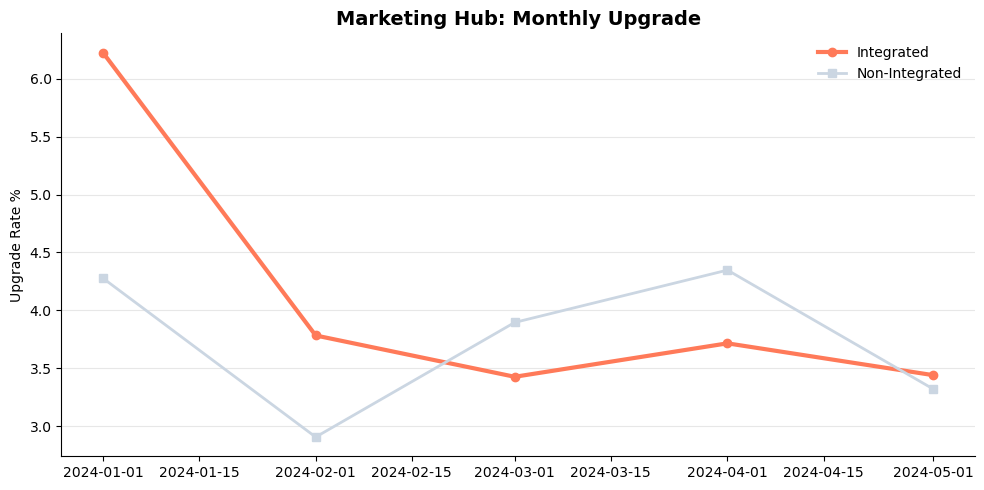

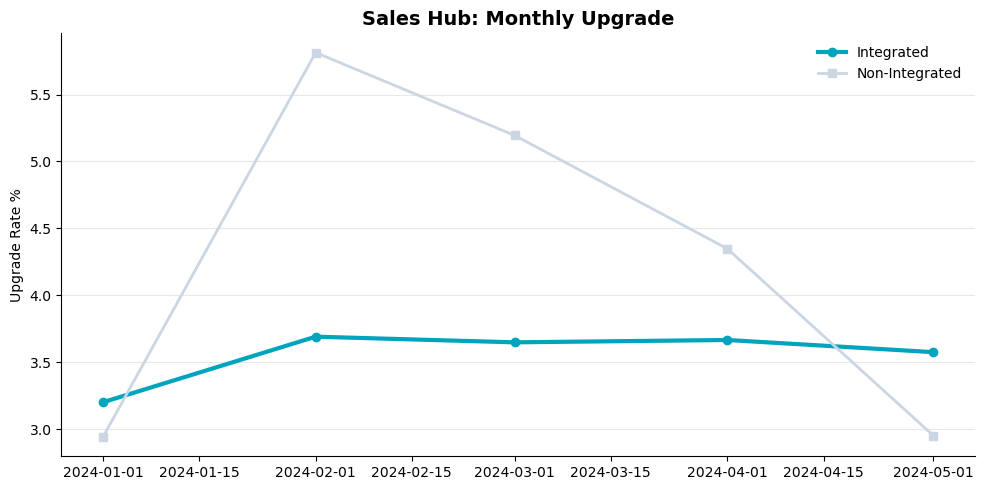

In [84]:
# integration users - monthly hub wise tier upgrade rate

import matplotlib.pyplot as plt

# 1. Define Tier Hierarchy
tier_map = {
    'Free': 0, 'Starter': 1, 'Professional': 2, 'Enterprise': 3, 
    None: 0, 'nan': 0, '': 0
}

# 2. Prepare Data
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])
df['mkt_rank'] = df['MARKETING_HUB_TIER'].map(tier_map).fillna(0)
df['sales_rank'] = df['SALES_HUB_TIER'].map(tier_map).fillna(0)
df['is_integrated'] = df['CUSTOMER_ID_y'].notna()

# 3. Consolidate to User-Month grain
monthly_status = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'is_integrated': 'max',
    'mkt_rank': 'max',
    'sales_rank': 'max'
}).reset_index()

# 4. Identify Upgrades (Month M0 -> M1)
monthly_status = monthly_status.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])
monthly_status['next_mkt_rank'] = monthly_status.groupby('CUSTOMER_ID_x')['mkt_rank'].shift(-1)
monthly_status['next_sales_rank'] = monthly_status.groupby('CUSTOMER_ID_x')['sales_rank'].shift(-1)

# Flag upgrades
monthly_status['mkt_upgrade'] = (monthly_status['next_mkt_rank'] > monthly_status['mkt_rank'])
monthly_status['sales_upgrade'] = (monthly_status['next_sales_rank'] > monthly_status['sales_rank'])

# Filter out last month (no lookahead possible)
max_month = monthly_status['SNAPSHOT_MONTH_x'].max()
analysis_df = monthly_status[monthly_status['SNAPSHOT_MONTH_x'] < max_month]

# 5. Build the Monthly Comparison Tables
def get_monthly_upgrade_table(df, upgrade_col):
    table = df.groupby(['SNAPSHOT_MONTH_x', 'is_integrated'])[upgrade_col].mean().reset_index()
    table[upgrade_col] *= 100 # Convert to %
    pivot = table.pivot(index='SNAPSHOT_MONTH_x', columns='is_integrated', values=upgrade_col)
    pivot.columns = ['Non-Integrated', 'Integrated']
    return pivot

mkt_upgrade_table = get_monthly_upgrade_table(analysis_df, 'mkt_upgrade')
sales_upgrade_table = get_monthly_upgrade_table(analysis_df, 'sales_upgrade')

# 6. Printing Tables for Excel
print("--- MONTHLY MARKETING HUB UPGRADE RATE (%) ---")
print(mkt_upgrade_table.reset_index().to_string(index=False))

print("\n--- MONTHLY SALES HUB UPGRADE RATE (%) ---")
print(sales_upgrade_table.reset_index().to_string(index=False))

# 7. Generate Visualizations
def plot_upgrade_trend(data, title, filename, color):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['Integrated'], marker='o', linewidth=3, color=color, label='Integrated')
    plt.plot(data.index, data['Non-Integrated'], marker='s', linewidth=2, color='#CBD6E2', label='Non-Integrated')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Upgrade Rate %')
    plt.legend(frameon=False)
    plt.grid(axis='y', alpha=0.3)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.savefig(filename)

# Marketing = Orange, Sales = Blue
plot_upgrade_trend(mkt_upgrade_table, 'Marketing Hub: Monthly Upgrade', 'mkt_upgrade_trend.png', '#FF7A59')
plot_upgrade_trend(sales_upgrade_table, 'Sales Hub: Monthly Upgrade', 'sales_upgrade_trend.png', '#00A4BD')

In [34]:
#Marketing & Sales Hub MRR for integrated vs non integrated customers

import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare MRR and Integration Flags
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])
df['mkt_mrr'] = df['MARKETING_HUB_MRR'].fillna(0)
df['sales_mrr'] = df['SALES_HUB_MRR'].fillna(0)
df['is_integrated'] = df['CUSTOMER_ID_y'].notna()

# 2. Aggregate to the Customer-Month Level
# We ensure we don't double count MRR if a user has multiple integrations
monthly_mrr_state = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'is_integrated': 'max',
    'mkt_mrr': 'first',
    'sales_mrr': 'first'
}).reset_index()

# 3. Calculate Total MRR per Group per Month
mrr_growth = monthly_mrr_state.groupby(['SNAPSHOT_MONTH_x', 'is_integrated']).agg({
    'mkt_mrr': 'sum',
    'sales_mrr': 'sum'
}).reset_index()

# 4. Map names for clarity
mrr_growth['Group'] = mrr_growth['is_integrated'].map({True: 'Integrated', False: 'Non-Integrated'})

# 5. Pivot for a "Side-by-Side" Growth Comparison
mkt_mrr_pivot = mrr_growth.pivot(index='SNAPSHOT_MONTH_x', columns='Group', values='mkt_mrr')
sales_mrr_pivot = mrr_growth.pivot(index='SNAPSHOT_MONTH_x', columns='Group', values='sales_mrr')

print("--- MARKETING HUB MRR GROWTH: INTEGRATED VS NON-INTEGRATED ---")
print(mkt_mrr_pivot.reset_index().to_string(index=False))

print("\n--- SALES HUB MRR GROWTH: INTEGRATED VS NON-INTEGRATED ---")
print(sales_mrr_pivot.reset_index().to_string(index=False))

# 6. Optional: Calculate Growth Rate (MoM)
mkt_mrr_pivot['Integrated_Growth_%'] = mkt_mrr_pivot['Integrated'].pct_change() * 100
sales_mrr_pivot['Integrated_Growth_%'] = sales_mrr_pivot['Integrated'].pct_change() * 100

--- MARKETING HUB MRR GROWTH: INTEGRATED VS NON-INTEGRATED ---
SNAPSHOT_MONTH_x  Integrated  Non-Integrated
      2024-01-01  2173733.97        28712.06
      2024-02-01  2324562.14        26767.17
      2024-03-01  2501436.26        26812.25
      2024-04-01  2650788.46        25741.37
      2024-05-01  2852726.56        26285.62
      2024-06-01  2999019.16        22929.30

--- SALES HUB MRR GROWTH: INTEGRATED VS NON-INTEGRATED ---
SNAPSHOT_MONTH_x  Integrated  Non-Integrated
      2024-01-01  1085235.90        31075.93
      2024-02-01  1160650.19        19644.48
      2024-03-01  1293162.39        19739.54
      2024-04-01  1430069.22        22240.98
      2024-05-01  1561256.68        28046.04
      2024-06-01  1717070.72        21680.52


In [37]:
# Cancellation MRR trends for sales and marketing hub users

# 1. Prepare Dates and Hub-Specific MRR
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])
df['mkt_mrr'] = df['MARKETING_HUB_MRR'].fillna(0)
df['sales_mrr'] = df['SALES_HUB_MRR'].fillna(0)
df['is_integrated'] = df['CUSTOMER_ID_y'].notna()

# 2. Consolidate to User-Month grain
monthly_df = df.groupby(['SNAPSHOT_MONTH_x', 'CUSTOMER_ID_x']).agg({
    'is_integrated': 'max',
    'mkt_mrr': 'first',
    'sales_mrr': 'first'
}).reset_index()

# 3. Sort to detect Churn (Month M0 exists, Month M1 does not)
monthly_df = monthly_df.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])
monthly_df['next_month_exists'] = monthly_df.groupby('CUSTOMER_ID_x')['SNAPSHOT_MONTH_x'].shift(-1).notna()

# 4. Identify Hub-Specific Cancellation MRR
# If the customer disappears next month, the current month's MRR is "Cancelled MRR"
monthly_df['mkt_cancel_mrr'] = 0
monthly_df.loc[(monthly_df['next_month_exists'] == False) & (monthly_df['mkt_mrr'] > 0), 'mkt_cancel_mrr'] = monthly_df['mkt_mrr']

monthly_df['sales_cancel_mrr'] = 0
monthly_df.loc[(monthly_df['next_month_exists'] == False) & (monthly_df['sales_mrr'] > 0), 'sales_cancel_mrr'] = monthly_df['sales_mrr']

# 5. Filter out the last month (cannot determine churn yet)
latest_month = monthly_df['SNAPSHOT_MONTH_x'].max()
analysis_df = monthly_df[monthly_df['SNAPSHOT_MONTH_x'] < latest_month]

# 6. Helper function to create the Pivot Table
def create_pivot(data, value_col):
    pivot = data.groupby(['SNAPSHOT_MONTH_x', 'is_integrated'])[value_col].sum().reset_index()
    pivot = pivot.pivot(index='SNAPSHOT_MONTH_x', columns='is_integrated', values=value_col).fillna(0)
    pivot.columns = ['Non-Integrated', 'Integrated']
    return pivot

# 7. Generate both tables
mkt_pivot = create_pivot(analysis_df, 'mkt_cancel_mrr')
sales_pivot = create_pivot(analysis_df, 'sales_cancel_mrr')

print("--- MARKETING HUB: MONTHLY CANCELLATION MRR ---")
print(mkt_pivot.reset_index().to_string(index=False))

print("\n--- SALES HUB: MONTHLY CANCELLATION MRR ---")
print(sales_pivot.reset_index().to_string(index=False))

<ipython-input-37-d6b00e1675e6>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[674.14  14.16   5.08 ...   7.47 416.28 291.41]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly_df.loc[(monthly_df['next_month_exists'] == False) & (monthly_df['mkt_mrr'] > 0), 'mkt_cancel_mrr'] = monthly_df['mkt_mrr']
<ipython-input-37-d6b00e1675e6>:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1587.03    4.27  303.74 ...   25.05  341.44 1251.61]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly_df.loc[(monthly_df['next_month_exists'] == False) & (monthly_df['sales_mrr'] > 0), 'sales_cancel_mrr'] = monthly_df['sales_mrr']


--- MARKETING HUB: MONTHLY CANCELLATION MRR ---
SNAPSHOT_MONTH_x  Non-Integrated  Integrated
      2024-01-01         1474.36    86228.32
      2024-02-01         2071.09   104588.72
      2024-03-01         2818.39   104012.27
      2024-04-01         1228.53    96670.86
      2024-05-01         2227.29   111307.86

--- SALES HUB: MONTHLY CANCELLATION MRR ---
SNAPSHOT_MONTH_x  Non-Integrated  Integrated
      2024-01-01            0.00     9330.74
      2024-02-01            0.00    14255.01
      2024-03-01          259.45    12508.05
      2024-04-01          143.25    10435.84
      2024-05-01         1674.20    17519.78


In [41]:
# Integration wise performance reach, stickiness, and MRR

# 1. Standardize Dates
df['SNAPSHOT_MONTH_x'] = pd.to_datetime(df['SNAPSHOT_MONTH_x'])

# 2. Calculate Total MRR per row
df['total_mrr'] = df['MARKETING_HUB_MRR'].fillna(0) + df['SALES_HUB_MRR'].fillna(0)

# 3. Identify Retention (Next Month Presence)
# Sort to ensure look-ahead logic works correctly per customer
df = df.sort_values(['CUSTOMER_ID_x', 'SNAPSHOT_MONTH_x'])
df['returned_next_month'] = df.groupby('CUSTOMER_ID_x')['SNAPSHOT_MONTH_x'].shift(-1).notna()

# 4. Filter for Integrated rows and handle the 6th-month look-ahead
# We exclude the most recent month for the retention rate because we don't know the future yet
latest_month = df['SNAPSHOT_MONTH_x'].max()
integrated_df = df[(df['CUSTOMER_ID_y'].notna()) & (df['SNAPSHOT_MONTH_x'] < latest_month)].copy()

# 5. Aggregate by the INTEGRATION column
integration_stats = integrated_df.groupby('INTEGRATION').agg(
    customer_count=('CUSTOMER_ID_x', 'nunique'),
    total_mrr=('total_mrr', 'sum'),
    retained_users=('returned_next_month', 'sum'),
    active_records=('returned_next_month', 'count')
).reset_index()

# 6. Calculate Retention Rate %
integration_stats['retention_rate_%'] = (integration_stats['retained_users'] / integration_stats['active_records']) * 100

# 7. Sort by MRR (Descending) to highlight high-value tools
integration_stats = integration_stats.sort_values('total_mrr', ascending=False)

print("--- INTEGRATION PERFORMANCE: REACH, VALUE, & STICKINESS ---")
print(integration_stats[['INTEGRATION', 'customer_count', 'total_mrr', 'retention_rate_%']].to_string(index=False))

--- INTEGRATION PERFORMANCE: REACH, VALUE, & STICKINESS ---
    INTEGRATION  customer_count  total_mrr  retention_rate_%
       Typeform            5022 8117057.53         98.161860
       LinkedIn            4249 7067337.78         95.329349
          Canva            4283 7057782.14         97.590508
     Google Ads            4063 6571135.43         99.530669
     Eventbrite            3870 6553194.44         96.587980
      Mailchimp            4649 6295862.39         99.486723
          Gmail            3657 6064984.32         99.791442
      Instagram            3743 6042308.54         98.379917
Google Calendar            3473 5900703.55         99.742170
       Calendly            3128 5349721.47         99.305436
   Facebook Ads            3401 4780458.11         99.864051
         Zapier            2177 4025768.60         99.818819
    FacebookAds             104   51693.69        100.000000
      GoogleAds             129   45790.54         99.224806
 GoogleCalendar          